In [1]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [18]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import cv2
import os
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [10]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [11]:
tabular_features = df.drop(['id', 'label'], axis=1)
labels = df['label']


In [14]:
corr_matrix = tabular_features.corr().abs()
print(corr_matrix)

                                                  log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity  \
log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity                                          1.000000   
log-sigma-1-0-mm-3D_ngtdm_Coarseness                                                      0.918320   
minor_axis_length                                                                         0.860863   
area                                                                                      0.842361   
log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity                                          0.880240   
...                                                                                            ...   
log-sigma-2-0-mm-3D_glcm_MCC                                                              0.191426   
LBP_hist_bin_7                                                                            0.326757   
log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis                                    

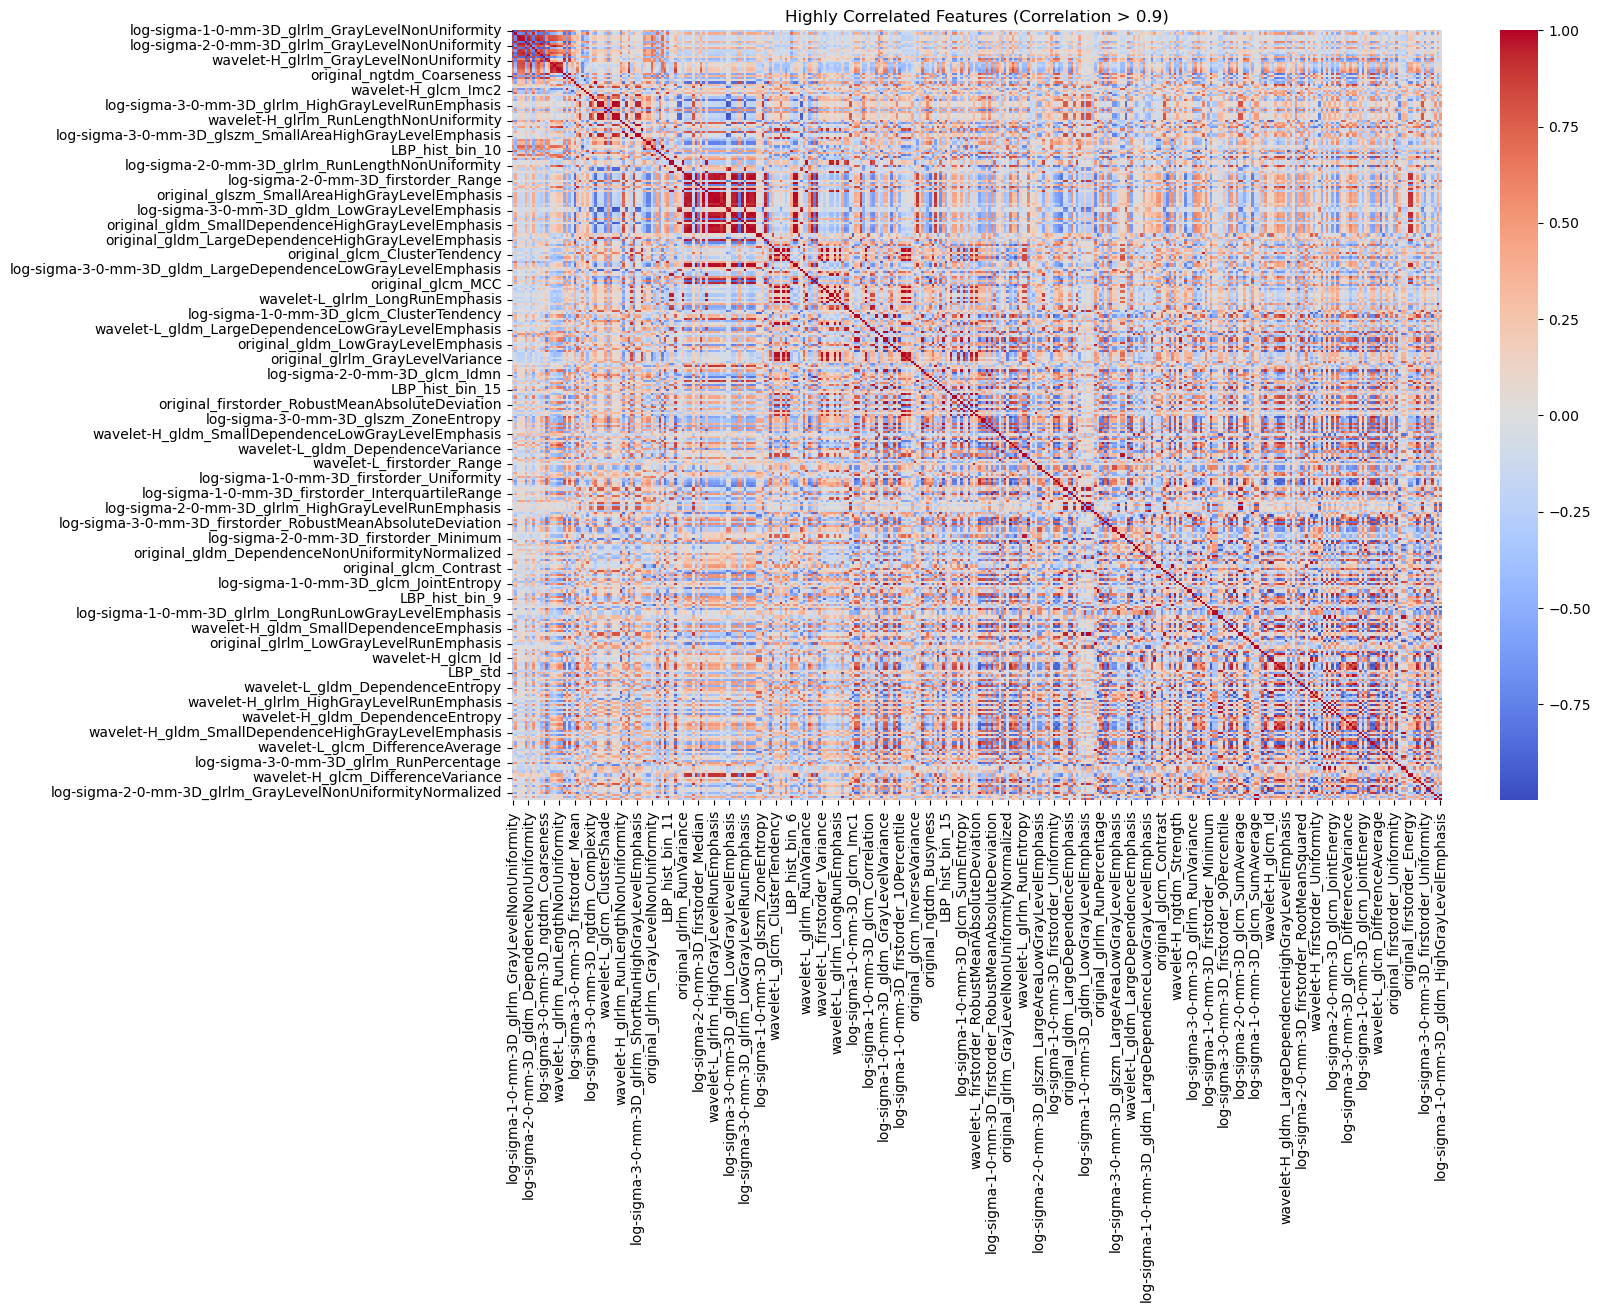

In [15]:
# 3. Filtered Heatmap (The "Worst Offenders")
# Only show features that have at least one correlation > 0.90 with another feature
threshold = 0.90
to_show = corr_matrix.index[(corr_matrix > threshold).sum() > 1]
filtered_corr = tabular_features[to_show].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', center=0)
plt.title(f"Highly Correlated Features (Correlation > {threshold})")
plt.show()

C:\Users\wesal\AppData\Local\Temp\ipykernel_31800\3311485099.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f"Visualizing Redundancy: {f1} vs {f2}\n(Correlation: {top_pairs[0]:.4f})")


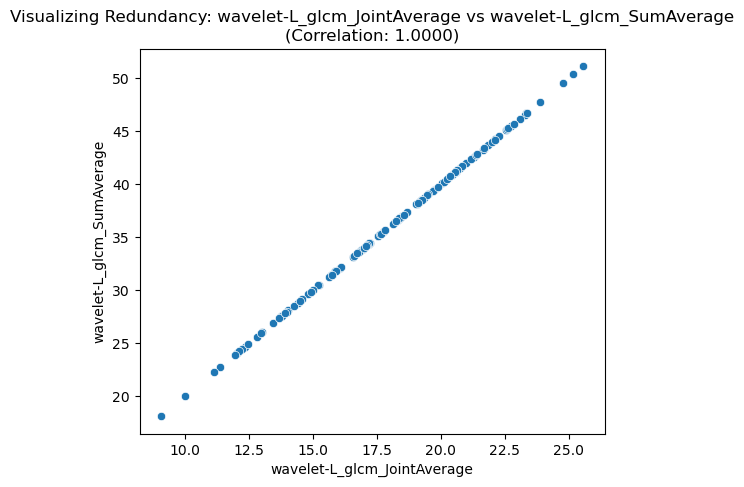

In [16]:
# 4. Spot Check: Top Redundant Pair
# Let's find the two most similar features and plot them
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_pairs = upper.unstack().sort_values(ascending=False).dropna()
f1, f2 = top_pairs.index[0]

plt.figure(figsize=(6, 5))
sns.scatterplot(x=tabular_features[f1], y=tabular_features[f2])
plt.title(f"Visualizing Redundancy: {f1} vs {f2}\n(Correlation: {top_pairs[0]:.4f})")
plt.xlabel(f1)
plt.ylabel(f2)
plt.show()

In [17]:
corr_matrix = tabular_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

tabular_features_reduced = tabular_features.drop(to_drop, axis=1)
print(f"Dropped {len(to_drop)} redundant features.")

Dropped 234 redundant features.


In [ ]:
# top50
selector = SelectKBest(score_func=f_classif, k=50)
x_tabular_selected = selector.fit_transform(tabular_features_reduced, labels)
selected_names = tabular_features_reduced.columns[selector.get_support()]
print("Top 10 features:", selected_names[:10].tolist())

Top 10 features: ['log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-1-0-mm-3D_ngtdm_Coarseness', 'minor_axis_length', 'log-sigma-2-0-mm-3D_ngtdm_Coarseness', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity', 'perimeter', 'wavelet-H_gldm_DependenceNonUniformity', 'log-sigma-3-0-mm-3D_ngtdm_Coarseness', 'log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity', 'wavelet-H_glrlm_GrayLevelNonUniformity']


In [21]:
Scaler = StandardScaler()
x_tabular_final = Scaler.fit_transform(x_tabular_selected)
y = labels.values

In [22]:
height, width = 256, 256 
batch_size=16

In [23]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [24]:
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, x_tabular_final, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp,
    test_size=0.176,   # 0.176 × 85% ≈ 15% of total
    random_state=42,
    stratify=y_temp
)


In [25]:
# y = labels.values if hasattr(labels, "values") else labels

# X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
#     X_img, x_tabular, y, test_size=0.2, random_state=42, stratify=y
# )
# print("Training samples:", X_img_train.shape[0])
# print("Validation samples:", X_img_val.shape[0])


In [26]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)
# x = Flatten()(x)
x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-4) , padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular_final.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 256, 256,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 85, 85,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 85, 85,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 85, 85,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      6,528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 125,441 (490.00 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 704 (2.75 KB)

In [27]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [28]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
    
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4839 - loss: 0.7342
Epoch 1: val_loss improved from None to 0.73468, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.4545 - loss: 0.7439 - val_accuracy: 0.5000 - val_loss: 0.7347
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6614 - loss: 0.6420
Epoch 2: val_loss improved from 0.73468 to 0.73344, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.6705 - loss: 0.6783 - val_accuracy: 0.6000 - val_loss: 0.7334
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6099 - loss: 0.6982
Epoch 3: val_loss improved from 0.73344 to 0.72937, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6136 - loss: 0.7012 - val_accuracy: 0.5500 - val_loss: 0.7294
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5155 - loss: 0.7551
Epoch 4: val_loss improved from 0.72937 to 0.72459, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.5227 - loss: 0.7461 - val_accuracy: 0.5500 - val_loss: 0.7246
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5162 - loss: 0.7074
Epoch 5: val_loss improved from 0.72459 to 0.71995, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.5114 - loss: 0.7259 - val_accuracy: 0.5500 - val_loss: 0.7200
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6141 - loss: 0.6885
Epoch 6: val_loss improved from 0.71995 to 0.71648, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.5455 - loss: 0.7114 - val_accuracy: 0.5000 - val_loss: 0.7165
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6908 - loss: 0.6438
Epoch 7: val_loss improved from 0.71648 to 0.71241, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6364 - loss: 0.6686 - val_accuracy: 0.5500 - val_loss: 0.7124
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5981 - loss: 0.6858
Epoch 8: val_loss improved from 0.71241 to 0.71048, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.6023 - loss: 0.6822 - val_accuracy: 0.5500 - val_loss: 0.7105
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5637 - loss: 0.7424
Epoch 9: val_loss improved from 0.71048 to 0.70755, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.5682 - loss: 0.7218 - val_accuracy: 0.5500 - val_loss: 0.7075
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6707 - loss: 0.6315
Epoch 10: val_loss improved from 0.70755 to 0.70619, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.6364 - loss: 0.6566 - val_accuracy: 0.5500 - val_loss: 0.7062
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5478 - loss: 0.6822
Epoch 11: val_loss improved from 0.70619 to 0.70603, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.6023 - loss: 0.6608 - val_accuracy: 0.5500 - val_loss: 0.7060
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7344 - loss: 0.6287
Epoch 12: val_loss improved from 0.70603 to 0.70393, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.7159 - loss: 0.6249 - val_accuracy: 0.5500 - val_loss: 0.7039
Epoch 13/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5481 - loss: 0.7108
Epoch 13: val_loss improved from 0.70393 to 0.70097, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.5909 - loss: 0.6830 - val_accuracy: 0.5500 - val_loss: 0.7010
Epoch 14/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7241 - loss: 0.6087
Epoch 14: val_loss improved from 0.70097 to 0.69767, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.7273 - loss: 0.6113 - val_accuracy: 0.5500 - val_loss: 0.6977
Epoch 15/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7444 - loss: 0.5976
Epoch 15: val_loss did not improve from 0.69767
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.6818 - loss: 0.6316 - val_accuracy: 0.5500 - val_loss: 0.6978
Epoch 16/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7145 - loss: 0.6455
Epoch 16: val_loss improved from 0.69767 to 0.69537, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6932 - loss: 0.6550 - val_accuracy: 0.5500 - val_loss: 0.6954
Epoch 17/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6767 - loss: 0.6610
Epoch 17: val_loss improved from 0.69537 to 0.68901, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.6705 - loss: 0.6490 - val_accuracy: 0.6000 - val_loss: 0.6890
Epoch 18/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8056 - loss: 0.5676
Epoch 18: val_loss improved from 0.68901 to 0.68444, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.6932 - loss: 0.6126 - val_accuracy: 0.6000 - val_loss: 0.6844
Epoch 19/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6172 - loss: 0.7201
Epoch 19: val_loss improved from 0.68444 to 0.67720, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6932 - loss: 0.6466 - val_accuracy: 0.6500 - val_loss: 0.6772
Epoch 20/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6911 - loss: 0.6302
Epoch 20: val_loss improved from 0.67720 to 0.67516, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.5795 - loss: 0.6494 - val_accuracy: 0.6500 - val_loss: 0.6752
Epoch 21/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6396 - loss: 0.6048
Epoch 21: val_loss improved from 0.67516 to 0.67211, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6818 - loss: 0.5921 - val_accuracy: 0.6500 - val_loss: 0.6721
Epoch 22/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7875 - loss: 0.5898
Epoch 22: val_loss improved from 0.67211 to 0.66177, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.7159 - loss: 0.6163 - val_accuracy: 0.6500 - val_loss: 0.6618
Epoch 23/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7766 - loss: 0.5778
Epoch 23: val_loss improved from 0.66177 to 0.65579, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7841 - loss: 0.5870 - val_accuracy: 0.6500 - val_loss: 0.6558
Epoch 24/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6880 - loss: 0.5976
Epoch 24: val_loss improved from 0.65579 to 0.65111, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.7159 - loss: 0.5885 - val_accuracy: 0.6500 - val_loss: 0.6511
Epoch 25/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6803 - loss: 0.6526
Epoch 25: val_loss improved from 0.65111 to 0.64455, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.6932 - loss: 0.6261 - val_accuracy: 0.6500 - val_loss: 0.6445
Epoch 26/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7511 - loss: 0.5797
Epoch 26: val_loss improved from 0.64455 to 0.63581, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.7159 - loss: 0.6139 - val_accuracy: 0.6500 - val_loss: 0.6358
Epoch 27/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6230 - loss: 0.6849
Epoch 27: val_loss improved from 0.63581 to 0.62371, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6705 - loss: 0.6471 - val_accuracy: 0.7000 - val_loss: 0.6237
Epoch 28/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6773 - loss: 0.6355
Epoch 28: val_loss improved from 0.62371 to 0.61307, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6818 - loss: 0.6346 - val_accuracy: 0.7000 - val_loss: 0.6131
Epoch 29/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7153 - loss: 0.6126
Epoch 29: val_loss improved from 0.61307 to 0.60276, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.7500 - loss: 0.5902 - val_accuracy: 0.7000 - val_loss: 0.6028
Epoch 30/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7155 - loss: 0.6046
Epoch 30: val_loss improved from 0.60276 to 0.59926, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.7045 - loss: 0.6068 - val_accuracy: 0.7500 - val_loss: 0.5993
Epoch 31/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7640 - loss: 0.5579
Epoch 31: val_loss improved from 0.59926 to 0.59807, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.6705 - loss: 0.6217 - val_accuracy: 0.7500 - val_loss: 0.5981
Epoch 32/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7897 - loss: 0.5576
Epoch 32: val_loss improved from 0.59807 to 0.58582, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.7386 - loss: 0.5644 - val_accuracy: 0.7500 - val_loss: 0.5858
Epoch 33/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7251 - loss: 0.5778
Epoch 33: val_loss improved from 0.58582 to 0.57238, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.7159 - loss: 0.5849 - val_accuracy: 0.7500 - val_loss: 0.5724
Epoch 34/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6830 - loss: 0.6553
Epoch 34: val_loss did not improve from 0.57238
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.6591 - loss: 0.6523 - val_accuracy: 0.7500 - val_loss: 0.5741
Epoch 35/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8265 - loss: 0.5587
Epoch 35: val_loss improved from 0.57238 to 0.56462, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7955 - loss: 0.5216 - val_accuracy: 0.7500 - val_loss: 0.5646
Epoch 36/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7757 - loss: 0.5391
Epoch 36: val_loss improved from 0.56462 to 0.55255, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.7955 - loss: 0.5193 - val_accuracy: 0.7500 - val_loss: 0.5525
Epoch 37/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7114 - loss: 0.5662
Epoch 37: val_loss did not improve from 0.55255
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.6932 - loss: 0.5954 - val_accuracy: 0.7500 - val_loss: 0.5554
Epoch 38/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7411 - loss: 0.5890
Epoch 38: val_loss did not improve from 0.55255
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.7500 - loss: 0.5804 - val_accuracy: 0.7500 - val_loss: 0.5532
Epoch 39/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7371 - loss: 0.5736
Epoch 39: val_loss improved from 0.55255 to 0.54366, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.7386 - loss: 0.5888 - val_accuracy: 0.7500 - val_loss: 0.5437
Epoch 40/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7746 - loss: 0.5591
Epoch 40: val_loss improved from 0.54366 to 0.53672, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.8182 - loss: 0.5274 - val_accuracy: 0.7500 - val_loss: 0.5367
Epoch 41/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6813 - loss: 0.5838
Epoch 41: val_loss improved from 0.53672 to 0.52265, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.6932 - loss: 0.5961 - val_accuracy: 0.7500 - val_loss: 0.5226
Epoch 42/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7781 - loss: 0.5992
Epoch 42: val_loss did not improve from 0.52265
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.7614 - loss: 0.5696 - val_accuracy: 0.7500 - val_loss: 0.5313
Epoch 43/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7488 - loss: 0.5384
Epoch 43: val_loss did not improve from 0.52265
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.7386 - loss: 0.5784 - val_accuracy: 0.7500 - val_loss: 0.5249
Epoch 44/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6718 - loss: 0.5658
Epoch 44: val_loss improved from 0.52265 to 0.51915, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.6818 - loss: 0.5719 - val_accuracy: 0.7500 - val_loss: 0.5191
Epoch 45/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8583 - loss: 0.4191
Epoch 45: val_loss improved from 0.51915 to 0.51569, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.8182 - loss: 0.4558 - val_accuracy: 0.7500 - val_loss: 0.5157
Epoch 46/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6751 - loss: 0.6135
Epoch 46: val_loss improved from 0.51569 to 0.51274, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.6818 - loss: 0.5989 - val_accuracy: 0.7500 - val_loss: 0.5127
Epoch 47/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6602 - loss: 0.6527
Epoch 47: val_loss improved from 0.51274 to 0.51101, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - accuracy: 0.7159 - loss: 0.5568 - val_accuracy: 0.7500 - val_loss: 0.5110
Epoch 48/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7267 - loss: 0.5147
Epoch 48: val_loss improved from 0.51101 to 0.50363, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 675ms/step - accuracy: 0.7500 - loss: 0.5427 - val_accuracy: 0.7500 - val_loss: 0.5036
Epoch 49/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7900 - loss: 0.5488
Epoch 49: val_loss improved from 0.50363 to 0.49670, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.7955 - loss: 0.5258 - val_accuracy: 0.7500 - val_loss: 0.4967
Epoch 50/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8516 - loss: 0.4638
Epoch 50: val_loss improved from 0.49670 to 0.48693, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 425ms/step - accuracy: 0.8182 - loss: 0.4912 - val_accuracy: 0.8000 - val_loss: 0.4869
Epoch 51/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7990 - loss: 0.5145
Epoch 51: val_loss improved from 0.48693 to 0.47498, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.7841 - loss: 0.5031 - val_accuracy: 0.8000 - val_loss: 0.4750
Epoch 52/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7346 - loss: 0.4963
Epoch 52: val_loss improved from 0.47498 to 0.46875, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.7841 - loss: 0.4610 - val_accuracy: 0.8000 - val_loss: 0.4688
Epoch 53/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7757 - loss: 0.5107
Epoch 53: val_loss improved from 0.46875 to 0.46641, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.7727 - loss: 0.5320 - val_accuracy: 0.8000 - val_loss: 0.4664
Epoch 54/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7698 - loss: 0.5157
Epoch 54: val_loss improved from 0.46641 to 0.46184, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.7727 - loss: 0.5182 - val_accuracy: 0.8000 - val_loss: 0.4618
Epoch 55/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6655 - loss: 0.5592
Epoch 55: val_loss did not improve from 0.46184
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.6818 - loss: 0.5466 - val_accuracy: 0.8000 - val_loss: 0.4723
Epoch 56/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7643 - loss: 0.5230
Epoch 56: val_loss did not improve from 0.46184
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.7273 - loss: 0.5626 - val_accuracy: 0.8000 - val_loss: 0.4651
Epoch 57/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8202 - loss: 0.4879
Epoch 57: val_loss did not improve from 0.46184
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7955 - loss: 0.5332 - val_accuracy: 0.7500 - val_loss: 0.4722
Epoch 58/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7827 - loss: 0.5433
Epoch 58: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.8182 - loss: 0.5016 - val_accuracy: 0.7500 - val_loss: 0.4560
Epoch 61/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7489 - loss: 0.4588
Epoch 61: val_loss did not improve from 0.45598
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.7841 - loss: 0.4696 - val_accuracy: 0.7500 - val_loss: 0.4615
Epoch 62/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7995 - loss: 0.4565
Epoch 62: val_loss did not improve from 0.45598
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.8523 - loss: 0.4370 - val_accuracy: 0.7500 - val_loss: 0.4584
Epoch 63/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9154 - loss: 0.3837
Epoch 63: val_loss did not improve from 0.45598
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.7955 - loss: 0.4593 - val_accuracy: 0.7500 - val_loss: 0.4615
Epoch 64/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8090 - loss: 0.5111
Epoch 64: val_loss improved from 0.

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.8068 - loss: 0.4907 - val_accuracy: 0.8000 - val_loss: 0.4430
Epoch 65/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8209 - loss: 0.4341
Epoch 65: val_loss improved from 0.44304 to 0.43251, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.8636 - loss: 0.4165 - val_accuracy: 0.8000 - val_loss: 0.4325
Epoch 66/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8502 - loss: 0.4118
Epoch 66: val_loss did not improve from 0.43251
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.8295 - loss: 0.4035 - val_accuracy: 0.7500 - val_loss: 0.4375
Epoch 67/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8331 - loss: 0.3820
Epoch 67: val_loss did not improve from 0.43251
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.8182 - loss: 0.4125 - val_accuracy: 0.7500 - val_loss: 0.4341
Epoch 68/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8162 - loss: 0.5178
Epoch 68: val_loss improved from 0.43251 to 0.40739, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.8295 - loss: 0.4604 - val_accuracy: 0.8500 - val_loss: 0.4074
Epoch 69/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8754 - loss: 0.3982
Epoch 69: val_loss improved from 0.40739 to 0.39454, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.8523 - loss: 0.3980 - val_accuracy: 0.8500 - val_loss: 0.3945
Epoch 70/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8382 - loss: 0.4378
Epoch 70: val_loss improved from 0.39454 to 0.38561, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.8295 - loss: 0.4143 - val_accuracy: 0.8500 - val_loss: 0.3856
Epoch 71/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8546 - loss: 0.5175
Epoch 71: val_loss improved from 0.38561 to 0.38290, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.8068 - loss: 0.5185 - val_accuracy: 0.8500 - val_loss: 0.3829
Epoch 72/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7300 - loss: 0.5258
Epoch 72: val_loss improved from 0.38290 to 0.38132, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.8068 - loss: 0.4525 - val_accuracy: 0.8500 - val_loss: 0.3813
Epoch 73/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7904 - loss: 0.4688
Epoch 73: val_loss did not improve from 0.38132
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.7841 - loss: 0.4803 - val_accuracy: 0.8500 - val_loss: 0.3889
Epoch 74/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7907 - loss: 0.4964
Epoch 74: val_loss improved from 0.38132 to 0.37882, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.7955 - loss: 0.4915 - val_accuracy: 0.8500 - val_loss: 0.3788
Epoch 75/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7871 - loss: 0.5283
Epoch 75: val_loss did not improve from 0.37882
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.7955 - loss: 0.4778 - val_accuracy: 0.8500 - val_loss: 0.3830
Epoch 76/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8855 - loss: 0.3698
Epoch 76: val_loss did not improve from 0.37882
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.8409 - loss: 0.4111 - val_accuracy: 0.8500 - val_loss: 0.3830
Epoch 77/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9012 - loss: 0.3826
Epoch 77: val_loss did not improve from 0.37882
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.8636 - loss: 0.3950 - val_accuracy: 0.8500 - val_loss: 0.3816
Epoch 78/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9074 - loss: 0.3820
Epoch 78: val_loss improved from 0.3

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9318 - loss: 0.3495 - val_accuracy: 0.8500 - val_loss: 0.3725
Epoch 79/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7784 - loss: 0.4237
Epoch 79: val_loss improved from 0.37247 to 0.36874, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8182 - loss: 0.4334 - val_accuracy: 0.8500 - val_loss: 0.3687
Epoch 80/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8771 - loss: 0.3857
Epoch 80: val_loss improved from 0.36874 to 0.35471, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.8636 - loss: 0.4170 - val_accuracy: 0.8500 - val_loss: 0.3547
Epoch 81/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8538 - loss: 0.4127
Epoch 81: val_loss improved from 0.35471 to 0.35263, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.8750 - loss: 0.3931 - val_accuracy: 0.8500 - val_loss: 0.3526
Epoch 82/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9122 - loss: 0.3511
Epoch 82: val_loss improved from 0.35263 to 0.35234, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.8750 - loss: 0.3765 - val_accuracy: 0.8500 - val_loss: 0.3523
Epoch 83/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8671 - loss: 0.3759
Epoch 83: val_loss improved from 0.35234 to 0.34887, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.8523 - loss: 0.3899 - val_accuracy: 0.8500 - val_loss: 0.3489
Epoch 84/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9111 - loss: 0.3420
Epoch 84: val_loss improved from 0.34887 to 0.34522, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9091 - loss: 0.3430 - val_accuracy: 0.8500 - val_loss: 0.3452
Epoch 85/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8177 - loss: 0.4370
Epoch 85: val_loss did not improve from 0.34522
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.8636 - loss: 0.3932 - val_accuracy: 0.8500 - val_loss: 0.3546
Epoch 86/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8528 - loss: 0.3601
Epoch 86: val_loss improved from 0.34522 to 0.34155, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9091 - loss: 0.3292 - val_accuracy: 0.8500 - val_loss: 0.3416
Epoch 87/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8563 - loss: 0.4339
Epoch 87: val_loss improved from 0.34155 to 0.33205, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.8409 - loss: 0.4392 - val_accuracy: 0.8500 - val_loss: 0.3320
Epoch 88/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8028 - loss: 0.3715
Epoch 88: val_loss improved from 0.33205 to 0.32066, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.8182 - loss: 0.3737 - val_accuracy: 0.8500 - val_loss: 0.3207
Epoch 89/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8404 - loss: 0.3931
Epoch 89: val_loss improved from 0.32066 to 0.31756, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.8182 - loss: 0.4177 - val_accuracy: 0.8500 - val_loss: 0.3176
Epoch 90/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9012 - loss: 0.3137
Epoch 90: val_loss improved from 0.31756 to 0.31630, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.8864 - loss: 0.3521 - val_accuracy: 0.8500 - val_loss: 0.3163
Epoch 91/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8512 - loss: 0.4015
Epoch 91: val_loss improved from 0.31630 to 0.31606, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.8182 - loss: 0.3979 - val_accuracy: 0.8500 - val_loss: 0.3161
Epoch 92/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9356 - loss: 0.2967
Epoch 92: val_loss did not improve from 0.31606
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.8864 - loss: 0.3429 - val_accuracy: 0.8500 - val_loss: 0.3165
Epoch 93/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8614 - loss: 0.4230
Epoch 93: val_loss improved from 0.31606 to 0.31245, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.8636 - loss: 0.3802 - val_accuracy: 0.8500 - val_loss: 0.3125
Epoch 94/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8357 - loss: 0.3572
Epoch 94: val_loss did not improve from 0.31245
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8636 - loss: 0.3758 - val_accuracy: 0.8500 - val_loss: 0.3132
Epoch 95/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8753 - loss: 0.3475
Epoch 95: val_loss improved from 0.31245 to 0.30020, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8864 - loss: 0.3521 - val_accuracy: 0.8500 - val_loss: 0.3002
Epoch 96/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7685 - loss: 0.4921
Epoch 96: val_loss improved from 0.30020 to 0.29520, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.7841 - loss: 0.4783 - val_accuracy: 0.8500 - val_loss: 0.2952
Epoch 97/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8043 - loss: 0.4039
Epoch 97: val_loss improved from 0.29520 to 0.29136, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.8295 - loss: 0.3454 - val_accuracy: 0.8500 - val_loss: 0.2914
Epoch 98/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9293 - loss: 0.3160
Epoch 98: val_loss did not improve from 0.29136
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.8977 - loss: 0.3175 - val_accuracy: 0.8500 - val_loss: 0.3004
Epoch 99/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8371 - loss: 0.3556
Epoch 99: val_loss improved from 0.29136 to 0.28698, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.8182 - loss: 0.3876 - val_accuracy: 0.8500 - val_loss: 0.2870
Epoch 100/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7850 - loss: 0.4696
Epoch 100: val_loss did not improve from 0.28698
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.8182 - loss: 0.4339 - val_accuracy: 0.8500 - val_loss: 0.2892
Epoch 101/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7329 - loss: 0.5111
Epoch 101: val_loss did not improve from 0.28698
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.8068 - loss: 0.4203 - val_accuracy: 0.8500 - val_loss: 0.3092
Epoch 102/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8613 - loss: 0.3944
Epoch 102: val_loss did not improve from 0.28698
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.8636 - loss: 0.3808 - val_accuracy: 0.8500 - val_loss: 0.3161
Epoch 103/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8653 - loss: 0.3507
Epoch 103: val_loss did not i

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.7841 - loss: 0.4282 - val_accuracy: 0.9000 - val_loss: 0.2858
Epoch 107/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9248 - loss: 0.2973
Epoch 107: val_loss improved from 0.28579 to 0.25888, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.8977 - loss: 0.3396 - val_accuracy: 0.9000 - val_loss: 0.2589
Epoch 108/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8544 - loss: 0.3750
Epoch 108: val_loss improved from 0.25888 to 0.25590, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.8864 - loss: 0.3345 - val_accuracy: 0.9000 - val_loss: 0.2559
Epoch 109/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9200 - loss: 0.3059
Epoch 109: val_loss did not improve from 0.25590
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.8864 - loss: 0.3297 - val_accuracy: 0.9000 - val_loss: 0.2646
Epoch 110/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7988 - loss: 0.4435
Epoch 110: val_loss did not improve from 0.25590
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.8295 - loss: 0.4157 - val_accuracy: 0.9000 - val_loss: 0.2641
Epoch 111/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8532 - loss: 0.3561
Epoch 111: val_loss improved from 0.25590 to 0.25356, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.8864 - loss: 0.3112 - val_accuracy: 0.9000 - val_loss: 0.2536
Epoch 112/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9142 - loss: 0.2855
Epoch 112: val_loss improved from 0.25356 to 0.25066, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.8636 - loss: 0.3370 - val_accuracy: 0.9000 - val_loss: 0.2507
Epoch 113/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9633 - loss: 0.2578
Epoch 113: val_loss improved from 0.25066 to 0.24898, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9318 - loss: 0.3144 - val_accuracy: 0.9000 - val_loss: 0.2490
Epoch 114/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8241 - loss: 0.3641
Epoch 114: val_loss improved from 0.24898 to 0.24493, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.8523 - loss: 0.3441 - val_accuracy: 0.9000 - val_loss: 0.2449
Epoch 115/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7840 - loss: 0.5452
Epoch 115: val_loss improved from 0.24493 to 0.24453, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.8409 - loss: 0.4235 - val_accuracy: 0.9000 - val_loss: 0.2445
Epoch 116/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8701 - loss: 0.3593
Epoch 116: val_loss did not improve from 0.24453
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.8750 - loss: 0.3354 - val_accuracy: 0.9000 - val_loss: 0.2521
Epoch 117/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9439 - loss: 0.2653
Epoch 117: val_loss did not improve from 0.24453
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.9205 - loss: 0.2727 - val_accuracy: 0.9000 - val_loss: 0.2531
Epoch 118/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8698 - loss: 0.3053
Epoch 118: val_loss did not improve from 0.24453
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.8977 - loss: 0.2761 - val_accuracy: 0.9000 - val_loss: 0.2456
Epoch 119/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7849 - loss: 0.4831
Epoch 119: val_loss did not 

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - accuracy: 0.9318 - loss: 0.2413 - val_accuracy: 0.9000 - val_loss: 0.2367
Epoch 121/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8740 - loss: 0.4031
Epoch 121: val_loss did not improve from 0.23675
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 677ms/step - accuracy: 0.8182 - loss: 0.4484 - val_accuracy: 0.9000 - val_loss: 0.2391
Epoch 122/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9468 - loss: 0.2451
Epoch 122: val_loss did not improve from 0.23675
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step - accuracy: 0.8864 - loss: 0.3133 - val_accuracy: 0.9000 - val_loss: 0.2370
Epoch 123/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8397 - loss: 0.3716
Epoch 123: val_loss did not improve from 0.23675
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 506ms/step - accuracy: 0.8636 - loss: 0.3525 - val_accuracy: 0.9000 - val_loss: 0.2370
Epoch 124/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8714 - loss: 0.3099
Epoch 124: val_loss impro

22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.8977 - loss: 0.2738 - val_accuracy: 0.9000 - val_loss: 0.2336
Epoch 125/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9106 - loss: 0.3291
Epoch 125: val_loss improved from 0.23362 to 0.22835, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9432 - loss: 0.2612 - val_accuracy: 0.9000 - val_loss: 0.2284
Epoch 126/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8545 - loss: 0.3324
Epoch 126: val_loss improved from 0.22835 to 0.22041, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.8750 - loss: 0.3172 - val_accuracy: 0.9000 - val_loss: 0.2204
Epoch 127/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8032 - loss: 0.4745
Epoch 127: val_loss improved from 0.22041 to 0.21664, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.8636 - loss: 0.4338 - val_accuracy: 0.9000 - val_loss: 0.2166
Epoch 128/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9311 - loss: 0.2447
Epoch 128: val_loss did not improve from 0.21664
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8864 - loss: 0.3142 - val_accuracy: 0.9000 - val_loss: 0.2204
Epoch 129/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8559 - loss: 0.4112
Epoch 129: val_loss did not improve from 0.21664
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8750 - loss: 0.3795 - val_accuracy: 0.9000 - val_loss: 0.2314
Epoch 130/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9279 - loss: 0.2412
Epoch 130: val_loss did not improve from 0.21664
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9318 - loss: 0.2339 - val_accuracy: 0.9000 - val_loss: 0.2253
Epoch 131/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9442 - loss: 0.2365
Epoch 131: val_loss did not i

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.8636 - loss: 0.3087 - val_accuracy: 0.9000 - val_loss: 0.2131
Epoch 135/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8881 - loss: 0.2704
Epoch 135: val_loss improved from 0.21313 to 0.20138, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.8068 - loss: 0.3905 - val_accuracy: 0.9500 - val_loss: 0.2014
Epoch 136/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9188 - loss: 0.2850
Epoch 136: val_loss improved from 0.20138 to 0.19479, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9091 - loss: 0.2610 - val_accuracy: 0.9500 - val_loss: 0.1948
Epoch 137/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8900 - loss: 0.3077
Epoch 137: val_loss improved from 0.19479 to 0.19198, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8750 - loss: 0.3324 - val_accuracy: 0.9500 - val_loss: 0.1920
Epoch 138/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8829 - loss: 0.3262
Epoch 138: val_loss improved from 0.19198 to 0.19150, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.8864 - loss: 0.3030 - val_accuracy: 0.9500 - val_loss: 0.1915
Epoch 139/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7868 - loss: 0.4424
Epoch 139: val_loss did not improve from 0.19150
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.7955 - loss: 0.3879 - val_accuracy: 0.9500 - val_loss: 0.1970
Epoch 140/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9706 - loss: 0.2002
Epoch 140: val_loss did not improve from 0.19150
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - accuracy: 0.9318 - loss: 0.2294 - val_accuracy: 0.9500 - val_loss: 0.1954
Epoch 141/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8871 - loss: 0.2696
Epoch 141: val_loss did not improve from 0.19150
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8523 - loss: 0.3127 - val_accuracy: 0.9000 - val_loss: 0.1989
Epoch 142/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8912 - loss: 0.3028
Epoch 142: val_loss did not 

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.8636 - loss: 0.3076 - val_accuracy: 0.9500 - val_loss: 0.1868
Epoch 144/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8020 - loss: 0.4356
Epoch 144: val_loss improved from 0.18678 to 0.18188, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.8977 - loss: 0.3045 - val_accuracy: 0.9500 - val_loss: 0.1819
Epoch 145/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8837 - loss: 0.2702
Epoch 145: val_loss did not improve from 0.18188
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.8750 - loss: 0.3209 - val_accuracy: 0.9500 - val_loss: 0.1897
Epoch 146/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9314 - loss: 0.2098
Epoch 146: val_loss did not improve from 0.18188
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.9091 - loss: 0.2711 - val_accuracy: 0.9500 - val_loss: 0.1881
Epoch 147/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9553 - loss: 0.2326
Epoch 147: val_loss improved from 0.18188 to 0.18071, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.8864 - loss: 0.3139 - val_accuracy: 0.9500 - val_loss: 0.1807
Epoch 148/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9246 - loss: 0.2827
Epoch 148: val_loss improved from 0.18071 to 0.17437, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.9318 - loss: 0.2309 - val_accuracy: 0.9500 - val_loss: 0.1744
Epoch 149/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8969 - loss: 0.2999
Epoch 149: val_loss improved from 0.17437 to 0.17263, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.8636 - loss: 0.3494 - val_accuracy: 0.9500 - val_loss: 0.1726
Epoch 150/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8992 - loss: 0.2679
Epoch 150: val_loss did not improve from 0.17263
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.9091 - loss: 0.2642 - val_accuracy: 0.9500 - val_loss: 0.1770
Epoch 151/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8928 - loss: 0.3097
Epoch 151: val_loss did not improve from 0.17263
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9205 - loss: 0.2681 - val_accuracy: 0.9500 - val_loss: 0.1779
Epoch 152/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8067 - loss: 0.3546
Epoch 152: val_loss did not improve from 0.17263
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.8636 - loss: 0.3177 - val_accuracy: 0.9500 - val_loss: 0.1729
Epoch 153/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8099 - loss: 0.4327
Epoch 153: val_loss did not

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.8864 - loss: 0.2498 - val_accuracy: 0.9500 - val_loss: 0.1701
Epoch 155/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9155 - loss: 0.2799
Epoch 155: val_loss improved from 0.17013 to 0.16653, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.8409 - loss: 0.3597 - val_accuracy: 0.9500 - val_loss: 0.1665
Epoch 156/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9044 - loss: 0.2718
Epoch 156: val_loss did not improve from 0.16653
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.8977 - loss: 0.2727 - val_accuracy: 0.9500 - val_loss: 0.1694
Epoch 157/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9267 - loss: 0.2196
Epoch 157: val_loss did not improve from 0.16653
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9205 - loss: 0.2398 - val_accuracy: 0.9500 - val_loss: 0.1711
Epoch 158/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9585 - loss: 0.2349
Epoch 158: val_loss did not improve from 0.16653
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.8864 - loss: 0.3488 - val_accuracy: 0.9500 - val_loss: 0.1785
Epoch 159/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9525 - loss: 0.2288
Epoch 159: val_loss did not i

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9205 - loss: 0.2279 - val_accuracy: 0.9500 - val_loss: 0.1640
Epoch 161/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9656 - loss: 0.1659
Epoch 161: val_loss improved from 0.16401 to 0.16302, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9545 - loss: 0.1898 - val_accuracy: 0.9500 - val_loss: 0.1630
Epoch 162/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9684 - loss: 0.2070
Epoch 162: val_loss did not improve from 0.16302
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9318 - loss: 0.2351 - val_accuracy: 0.9500 - val_loss: 0.1688
Epoch 163/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9586 - loss: 0.2454
Epoch 163: val_loss did not improve from 0.16302
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.8977 - loss: 0.3559 - val_accuracy: 0.9500 - val_loss: 0.1743
Epoch 164/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9398 - loss: 0.2021
Epoch 164: val_loss improved from 0.16302 to 0.16119, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.8864 - loss: 0.2817 - val_accuracy: 0.9500 - val_loss: 0.1612
Epoch 165/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8644 - loss: 0.3066
Epoch 165: val_loss did not improve from 0.16119
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.8636 - loss: 0.3128 - val_accuracy: 0.9500 - val_loss: 0.1651
Epoch 166/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8582 - loss: 0.2743
Epoch 166: val_loss did not improve from 0.16119
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.8523 - loss: 0.3776 - val_accuracy: 0.9500 - val_loss: 0.1764
Epoch 167/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9491 - loss: 0.2145
Epoch 167: val_loss did not improve from 0.16119
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.8864 - loss: 0.2667 - val_accuracy: 0.9000 - val_loss: 0.1826
Epoch 168/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9326 - loss: 0.2209
Epoch 168: val_loss did not i

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - accuracy: 0.9659 - loss: 0.2046 - val_accuracy: 0.9500 - val_loss: 0.1610
Epoch 175/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8559 - loss: 0.3852
Epoch 175: val_loss improved from 0.16105 to 0.15114, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.8068 - loss: 0.4449 - val_accuracy: 0.9500 - val_loss: 0.1511
Epoch 176/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8651 - loss: 0.3350
Epoch 176: val_loss did not improve from 0.15114
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.8864 - loss: 0.2763 - val_accuracy: 0.9500 - val_loss: 0.1576
Epoch 177/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9255 - loss: 0.2810
Epoch 177: val_loss did not improve from 0.15114
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.9091 - loss: 0.3321 - val_accuracy: 0.9500 - val_loss: 0.1562
Epoch 178/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9132 - loss: 0.2283
Epoch 178: val_loss improved from 0.15114 to 0.14575, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.8977 - loss: 0.2353 - val_accuracy: 0.9500 - val_loss: 0.1458
Epoch 179/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9362 - loss: 0.2372
Epoch 179: val_loss did not improve from 0.14575
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.9091 - loss: 0.2686 - val_accuracy: 0.9500 - val_loss: 0.1522
Epoch 180/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8759 - loss: 0.3640
Epoch 180: val_loss improved from 0.14575 to 0.13987, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.8750 - loss: 0.3436 - val_accuracy: 0.9500 - val_loss: 0.1399
Epoch 181/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9372 - loss: 0.2109
Epoch 181: val_loss improved from 0.13987 to 0.13495, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.9318 - loss: 0.2156 - val_accuracy: 0.9500 - val_loss: 0.1349
Epoch 182/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9379 - loss: 0.1990
Epoch 182: val_loss improved from 0.13495 to 0.13468, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.9091 - loss: 0.2625 - val_accuracy: 0.9500 - val_loss: 0.1347
Epoch 183/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9124 - loss: 0.2844
Epoch 183: val_loss improved from 0.13468 to 0.13371, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.9432 - loss: 0.2203 - val_accuracy: 0.9500 - val_loss: 0.1337
Epoch 184/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9801 - loss: 0.1499
Epoch 184: val_loss improved from 0.13371 to 0.13310, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.9773 - loss: 0.1549 - val_accuracy: 0.9500 - val_loss: 0.1331
Epoch 185/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8974 - loss: 0.2490
Epoch 185: val_loss did not improve from 0.13310
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.8409 - loss: 0.3155 - val_accuracy: 0.9500 - val_loss: 0.1356
Epoch 186/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9815 - loss: 0.1396
Epoch 186: val_loss did not improve from 0.13310
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.9659 - loss: 0.1557 - val_accuracy: 0.9500 - val_loss: 0.1356
Epoch 187/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9504 - loss: 0.2164
Epoch 187: val_loss improved from 0.13310 to 0.13253, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.8864 - loss: 0.2994 - val_accuracy: 0.9500 - val_loss: 0.1325
Epoch 188/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8798 - loss: 0.2794
Epoch 188: val_loss improved from 0.13253 to 0.13130, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.9091 - loss: 0.2606 - val_accuracy: 0.9500 - val_loss: 0.1313
Epoch 189/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9516 - loss: 0.1841
Epoch 189: val_loss improved from 0.13130 to 0.12495, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9432 - loss: 0.1968 - val_accuracy: 0.9500 - val_loss: 0.1249
Epoch 190/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9496 - loss: 0.1866
Epoch 190: val_loss improved from 0.12495 to 0.11921, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9545 - loss: 0.1765 - val_accuracy: 0.9500 - val_loss: 0.1192
Epoch 191/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8820 - loss: 0.3248
Epoch 191: val_loss did not improve from 0.11921
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8523 - loss: 0.3545 - val_accuracy: 0.9500 - val_loss: 0.1348
Epoch 192/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9311 - loss: 0.1970
Epoch 192: val_loss did not improve from 0.11921
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9091 - loss: 0.2765 - val_accuracy: 0.9500 - val_loss: 0.1372
Epoch 193/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9750 - loss: 0.1905
Epoch 193: val_loss did not improve from 0.11921
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9545 - loss: 0.1983 - val_accuracy: 0.9500 - val_loss: 0.1417
Epoch 194/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8569 - loss: 0.3196
Epoch 194: val_loss did not i

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.8977 - loss: 0.2665 - val_accuracy: 0.9500 - val_loss: 0.1176
Epoch 197/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9880 - loss: 0.1519
Epoch 197: val_loss did not improve from 0.11764
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9773 - loss: 0.1561 - val_accuracy: 0.9500 - val_loss: 0.1226
Epoch 198/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8372 - loss: 0.3211
Epoch 198: val_loss did not improve from 0.11764
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.8864 - loss: 0.2632 - val_accuracy: 0.9500 - val_loss: 0.1223
Epoch 199/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9581 - loss: 0.1961
Epoch 199: val_loss improved from 0.11764 to 0.11326, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.8977 - loss: 0.3011 - val_accuracy: 0.9500 - val_loss: 0.1133
Epoch 200/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9217 - loss: 0.2189
Epoch 200: val_loss improved from 0.11326 to 0.10300, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.9432 - loss: 0.1958 - val_accuracy: 0.9500 - val_loss: 0.1030
Epoch 201/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9217 - loss: 0.2655
Epoch 201: val_loss did not improve from 0.10300
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9432 - loss: 0.2318 - val_accuracy: 0.9500 - val_loss: 0.1052
Epoch 202/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8574 - loss: 0.3234
Epoch 202: val_loss did not improve from 0.10300
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8750 - loss: 0.2878 - val_accuracy: 0.9500 - val_loss: 0.1162
Epoch 203/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9526 - loss: 0.1815
Epoch 203: val_loss did not improve from 0.10300
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9318 - loss: 0.2032 - val_accuracy: 0.9500 - val_loss: 0.1225
Epoch 204/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8588 - loss: 0.2947
Epoch 204: val_loss did not i

In [29]:
from sklearn.metrics import roc_auc_score

val_loss, val_acc = model.evaluate([X_img_val, X_tab_val], y_val)
print("Validation accuracy:", val_acc)
y_pred = model.predict([X_img_val, X_tab_val])
y_prob = model.predict([X_img_val, X_tab_val]).ravel()
y_pred = (y_prob > 0.5).astype(int)
auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", auc)

# Validation is for tuning.
# Testing is for reporting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9500 - loss: 0.1030
Validation accuracy: 0.949999988079071
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
ROC AUC: 1.0


In [30]:
from sklearn.metrics import roc_auc_score
test_loss, test_acc = model.evaluate(
    [X_img_test, X_tab_test],
    y_test
)

y_prob_test = model.predict([X_img_test, X_tab_test]).ravel()
y_pred_test = (y_prob_test > 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_prob_test)

print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_auc)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 1.0000 - loss: 0.0705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Test accuracy: 1.0
Test ROC AUC: 1.0


In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


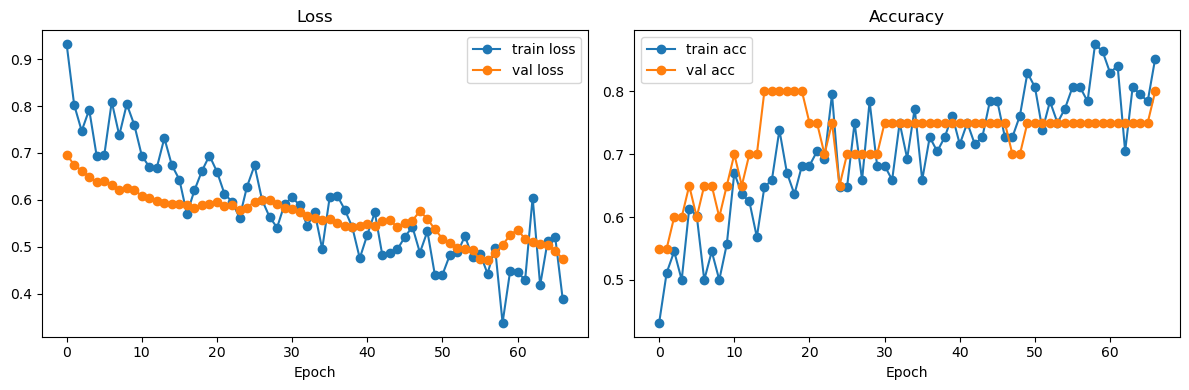

In [ ]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()